<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster/blob/main/lab_60_cats_and_dogs_keras_rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Cats and Dogs

- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다
- 검증은 1000개의 이미지 사용 

## 데이터 다운로드

In [ ]:
import os, os.path, shutil
# import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   164M      0 --:--:-- --:--:-- --:--:--  165M


In [ ]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!apt-get install tree
# command-line tool for handling packages in linux
# !pip install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (98.4 kB/s)
Selecting previously unselected package tree.
(Reading database ... 148489 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -d .

.
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
└── sample_data

8 directories


In [ ]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_dogs_dir

'./cats_and_dogs_filtered/train/dogs'

## 파일 확인

In [ ]:
os.listdir(train_dogs_dir)[:10]

['dog.917.jpg',
 'dog.605.jpg',
 'dog.541.jpg',
 'dog.482.jpg',
 'dog.252.jpg',
 'dog.665.jpg',
 'dog.862.jpg',
 'dog.902.jpg',
 'dog.359.jpg',
 'dog.223.jpg']

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.377.jpg', 'cat.922.jpg', 'cat.283.jpg', 'cat.52.jpg', 'cat.514.jpg', 'cat.493.jpg', 'cat.622.jpg', 'cat.123.jpg', 'cat.872.jpg', 'cat.587.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 확인

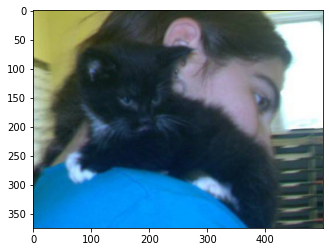

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
img_path = os.path.join(train_cats_dir, train_cat_fnames[0]) 
img = mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
type(img), img.shape, img[0,0,:], img.max()  # 8-bits

(numpy.ndarray, (375, 499, 3), array([191, 190,  97], dtype=uint8), 255)

## 간단한 CNN을 사용한 모델


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 

"""
keras에서는 이미지데이터 학습을 쉽게하도록 하기위해 다양한 패키지를 제공한다. 그 중 하나가 ImageDataGenerator 클래스이다. ImageDataGenerator 클래스를 통해 객체를 생성할 때 파라미터를 전달해주는 것을 통해 데이터의 전처리를 쉽게할 수 있고, 또 이 객체의 
flow_from_directory 메소드를 활용하면 폴더 형태로된 데이터 구조를 바로 가져와서 사용할 수 있다. 이 과정은 매우 직관적이고 코드도 ImageDataGenerator를 사용하지 않는 방법에 비해 상당히 짧아진다.

출처: https://3months.tistory.com/199 [Deep Play]
"""

#### ImageDataGenerator() object
- Generate batches of tensor image data with real-time data augmentation. The data 
  will be looped over (in batches).
- flow_from_dataframe() method: Takes the dataframe and the path to a directory and 
    generates batches of augmented/normalized data.
- flow_from_directory() method: Takes the path to a directory & generates batches of 
    augmented data.

In [ ]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
______________________________________

In [ ]:
# for exercise (just for checking) - it will loop forever, so you need break !
for data_batch, labels_batch in train_generator:
    print(data_batch.shape, labels_batch.shape)
    break

(20, 150, 150, 3) (20,)


- .fit은 전체 학습 데이터 세트가 메모리에 맞고 데이터 증가가 적용되지 않을 때 사용됩니다.
- .fit_generator는 메모리에 맞출 거대한 데이터 세트가 있거나 데이터 증가를 적용해야 할 때 사용됩니다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 41s 112ms/step - loss: 0.6879 - acc: 0.5350 - val_loss: 0.6642 - val_acc: 0.5800
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 0.6555 - acc: 0.6185 - val_loss: 0.6275 - val_acc: 0.6580
Epoch 3/10
100/100 [==============================] - 11s 113ms/step - loss: 0.6075 - acc: 0.6660 - val_loss: 0.5994 - val_acc: 0.6790
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.5644 - acc: 0.7060 - val_loss: 0.5656 - val_acc: 0.7070
Epoch 5/10
100/100 [==============================] - 11s 115ms/step - loss: 0.5369 - acc: 0.7330 - val_loss: 0.5560 - val_acc: 0.7170
Epoch 6/10
100/100 [==============================] - 11s 115ms/step - loss: 0.5079 - acc: 0.7510 - val_loss: 0.5469 - val_acc: 0.7150
Epoch 7/10
100/100 [==============================] - 11s 115ms/step - loss: 0.4820 - acc: 0.7645 - val_loss: 0.5476 - val_acc: 0.7290
Epoch 8/10
100/100 [==============================] - 1

In [ ]:
model.save('./sample_data/cats_and_dogs_from_lab60.h5')  # will be used later in this code
# or tf.keras.models.save_model()
model = keras.models.load_model('./sample_data/cats_and_dogs_from_lab60.h5')

- there are two types for saving the models
  - tensorflow SavedModel (recommended)(default for model.save())
  - keras H5 (파일명을 '.h5' 로 주거나 parameter format='h5') 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#### When we call the .fit() function it makes assumptions:

- The entire training set can fit into the Random Access Memory (RAM) of the computer.
- Calling the model .fit method for a second time is not going to reinitialize our 
  already trained weights, which means we can actually make consecutive calls to fit 
  if we want to and then manage it properly.
- There is no need for using the Keras generators(i.e no data argumentation)
- Raw data is itself used for training our network and our raw data will only fit 
  into the memory.

#### When we call the .fit_generator() function it makes assumptions:

- generator 함수를 사용해야 함.
- Keras is first calling the generator function(dataAugmentaion)
- Generator function(dataAugmentaion) provides a batch_size of 32 to our .fit_generator() function.
- our .fit_generator() function first accepts a batch of the dataset, then performs 
  backpropagation on it, and then updates the weights in our model.
- For the number of epochs specified(10 in our case) the process is repeated.
- returns a History object. Its History.history attribute is a record of training 
  loss values and metrics values at successive epochs, as well as validation loss 
  values and validation metrics values (if applicable).

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

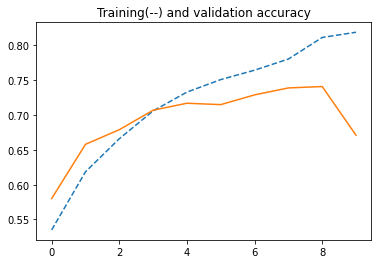

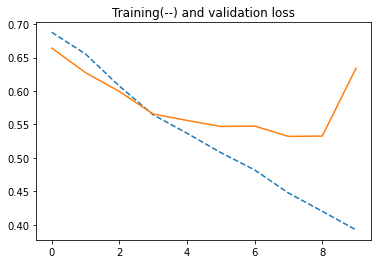

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')


### 과대적합이 발생한 것을 알 수 있다.
- 모델은 복잡한데 적은 수의 데이터를 반복 (이포크) 사용하여 훈련시킨 때문으로 보임.



# data augmentation과 드롭아웃 사용
- 드롭 아웃 계층은 훈련 시간 동안 각 단계의 rate 를 사용하여 입력 단위를 무작위로 0으로 설정하여 ovefitting 을 방지.
- 0 으로 설정되지 않은 입력은 모든 입력에 대한 합계가 변경되지 않도록 1 / (1-rate)만큼 scaled up.
- training 할 때만 적용되고 inference 할 때에는 drop 되지 않음.

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)


model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### augmented 된 훈련 이미지는 마지막 셀에서 보세요...^^

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 22s 214ms/step - loss: 0.6933 - acc: 0.5035 - val_loss: 0.6763 - val_acc: 0.6130
Epoch 2/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6795 - acc: 0.5600 - val_loss: 0.6540 - val_acc: 0.5930
Epoch 3/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6645 - acc: 0.5815 - val_loss: 0.6525 - val_acc: 0.5850
Epoch 4/30
100/100 [==============================] - 21s 207ms/step - loss: 0.6608 - acc: 0.5910 - val_loss: 0.6289 - val_acc: 0.6390
Epoch 5/30
100/100 [==============================] - 21s 207ms/step - loss: 0.6435 - acc: 0.6145 - val_loss: 0.6109 - val_acc: 0.6810
Epoch 6/30
100/100 [==============================] - 21s 209ms/step - loss: 0.6353 - acc: 0.6220 - val_loss: 0.5917 - val_acc: 0.6970
Epoch 7/30
100/100 [==============================] - 21s 207ms/step - loss: 0.6245 - acc: 0.6470 - val_loss: 0.5871 - val_acc: 0.6720
Epoch 8/30
100/100 [==============================] - 2

Text(0.5, 1.0, 'Training(--) and validation loss')

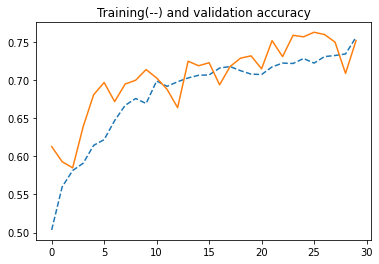

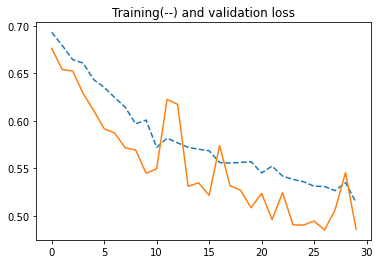

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않음을 볼 수 있다.

# Random 하게 데이터 증식한 훈련 이미지 그리기 (from the Keras book)


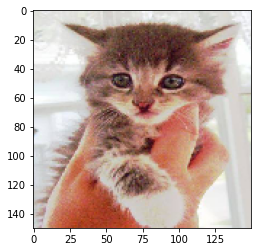

In [ ]:
from keras.preprocessing import image   # 이미지 전처리 유틸리티 모듈

fnames = sorted([os.path.join(train_cats_dir, fname) for 
                fname in os.listdir(train_cats_dir)])
img_path = fnames[3]  # 증식할 이미지 선택
img = image.load_img(img_path, target_size=(150,150)) # 이미지를 읽고 크기 변경

plt.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True)

In [ ]:
# ImageDataGenerator.flow(): Takes data & label arrays, generates batches of augmented data.
# 배치 데이터를 기대하기 떄문에 샘플 데이터에 배치 차원을 추가하여 4-d 텐서로 만듬.

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)    # (1,150,150,3) 크기로 변환
print(x.shape)

(1, 150, 150, 3)


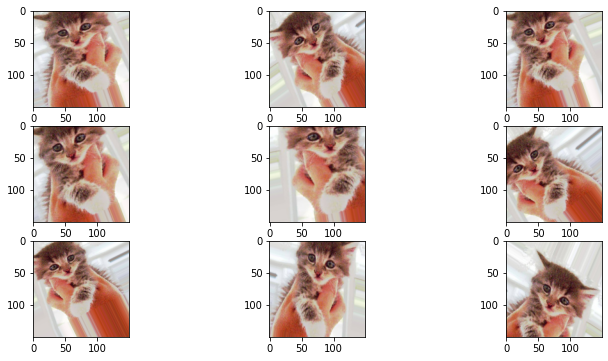

In [ ]:
i = 0
plt.figure(figsize=(12,6))
for batch in train_datagen.flow(x, batch_size=1):   # endless loop (need break)
    plt.subplot(3,3,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i % 9 == 0:
        break
plt.show()

# For your reference

In [ ]:
a = np.array([[1,2],[3,4]])
print(a.shape)
print(a.reshape(4,1))
print((1,) + a.shape)
(1,4) + (2,3)   # tuple concatenation

(2, 2)
[[1]
 [2]
 [3]
 [4]]
(1, 2, 2)


(1, 4, 2, 3)

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (60000, 1, 28, 28) (28 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (60000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


(9, 1, 28, 28)


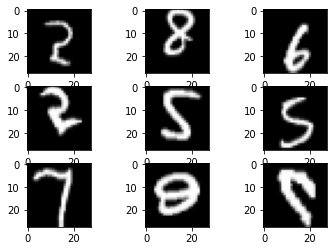

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],1,28,28).astype('float32')
datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)
datagen.fit(X_train)
batch_size=9
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
    print(X_batch.shape)
    for i in range(batch_size):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

# Visualizing Filters
- refer to lab61

# Visualizing Convnet Training 
- from Deep Learning with Python, by Francois Chollet
- 딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./sample_data/cats_and_dogs_from_lab60.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

(1, 150, 150, 3) <class 'numpy.ndarray'>


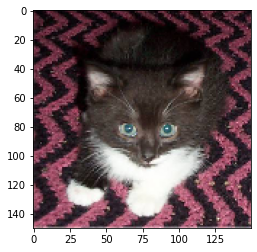

In [ ]:
img_path = './cats_and_dogs_filtered/train/cats/cat.46.jpg'


from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)   # image 를 4D 텐서로
img_tensor /= 255.
print(img_tensor.shape, type(img_tensor))
# plotting the image
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 층의 활성화마다 하나씩 8개의 numpy 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [ ]:
len(activations)

8

In [ ]:
[activations[i].shape for i in range(8)]

[(1, 148, 148, 32),
 (1, 74, 74, 32),
 (1, 72, 72, 64),
 (1, 36, 36, 64),
 (1, 34, 34, 128),
 (1, 17, 17, 128),
 (1, 15, 15, 128),
 (1, 7, 7, 128)]

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


- 32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

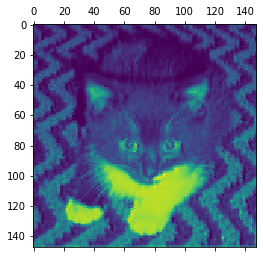

In [ ]:
# Matplotlib matshow is a wrapper for imshow , in that it "sets origin to 'upper', 
# 'interpolation' to 'nearest' and 'aspect' to equal." So while matshow always uses 
# interpolation="nearest" , imshow by default has interpolation=None .
plt.matshow(first_layer_activation[0, :, :, 7], 
            cmap='viridis')                      # Display an array as a matrix 
                                                 # in a new figure window.
plt.show()

- 대각선 에지를 표현하는 인코딩 정도로 보임

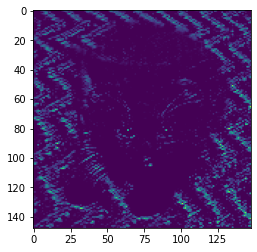

In [ ]:
plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

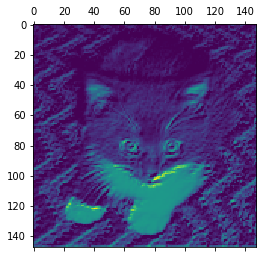

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

- 밝은 부분?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


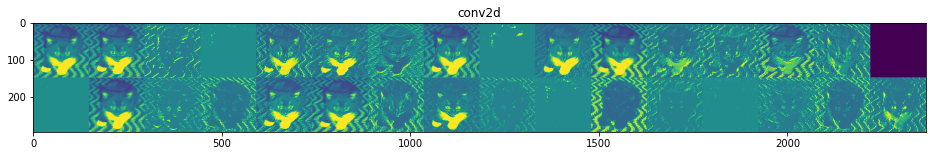

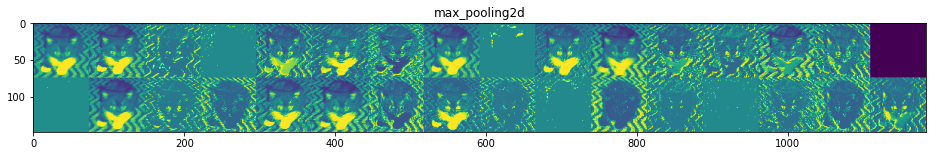

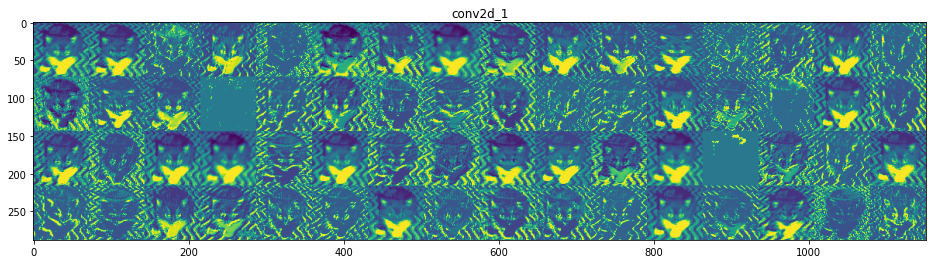

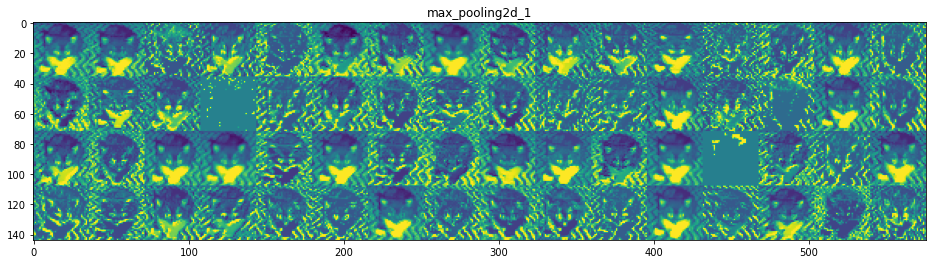

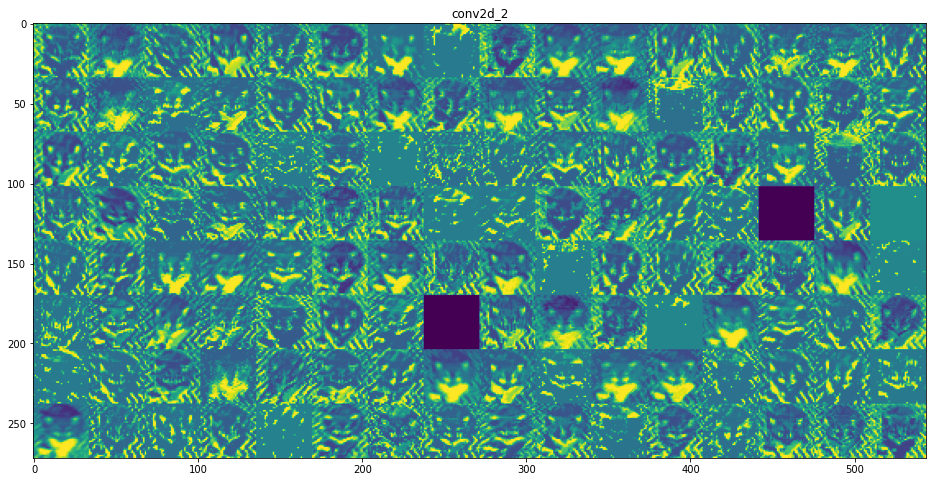

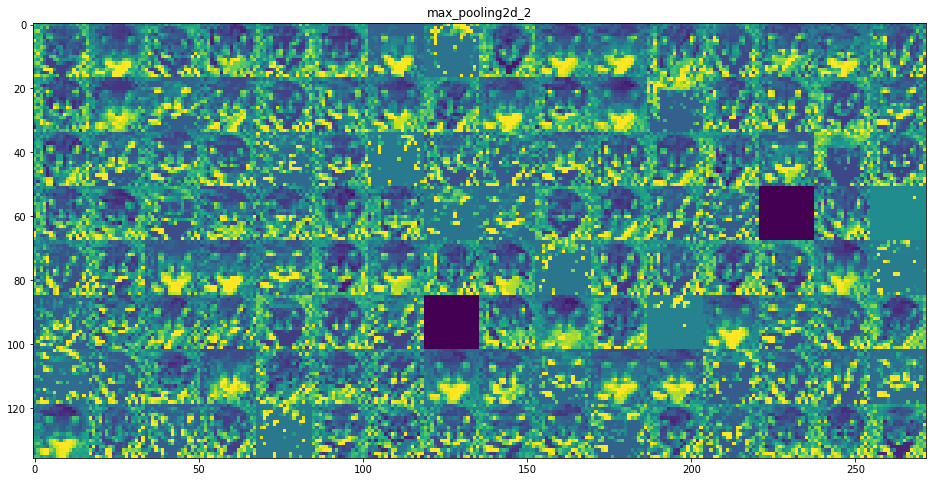

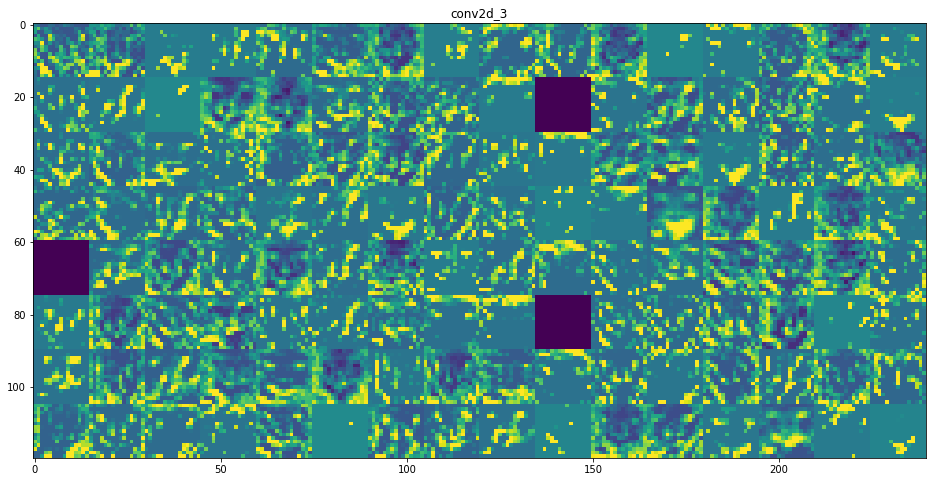

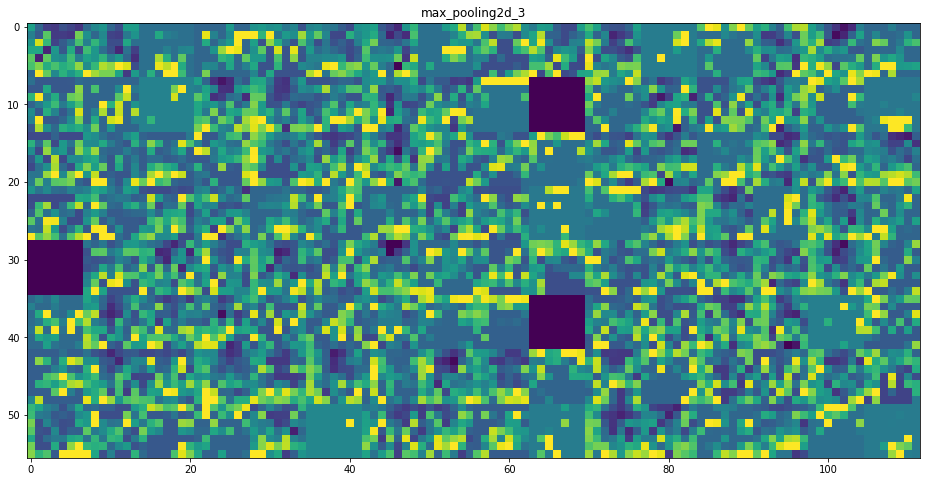

In [ ]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

- 몇 가지 주목할 내용이 있습니다:
  - 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됨을 볼 수 있다.
  - 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워진다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작한다. 
  - 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가한다.
  - 비어 있는 활성화가 층이 깊어짐에 따라 늘어난다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생긴다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미한다.

# 연습

In [ ]:
a = np.arange(-5, 5)
print(a)
np.clip(a, 0, 3)

[-5 -4 -3 -2 -1  0  1  2  3  4]


array([0, 0, 0, 0, 0, 0, 1, 2, 3, 3])